# An end-to-end Solution for covid-19 predictions
by: Kaike W. Reis

## Briefly overview
During this notebook construction I learned a lot in Data Analytics! Here I present a solution for proposed tasks. But before you continue this reading, understand that this a complex challenge with commom problems in machine learning field such as:
- **Great number of missing values and how you can solve it**
- **Imbalanced label for covid-19 exams results**

Others situations will be describe during this notebook.

## Steps
- Missing Data Analysis & Pre-processing data
- Data assumptions - a biological assessment to reduce missing values and data complexity
- Impute or Not Impute? that is the question
- Exploratory Data Analysis
- Predictive Analysis: general infos
- Model Development: Task 1
- Model Development: Task 2
- Conclusions

## Notebook Libraries

In [1]:
# Standard modules
import numpy as np
import pandas as pd

# Missing Analysis & Pre-processing
from sklearn.preprocessing import StandardScaler
import missingno as msno

# Missing imputation
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer as MICE

# Model development
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

# Graphical modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Display module (show all dataset)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.display import display

Using TensorFlow backend.


# Missing Data Analysis & Pre-processing data

## Importing data

In [2]:
# Importing raw dataset
dataset_raw = pd.read_excel('/kaggle/input/covid19/dataset.xlsx')

In [3]:
# Drop unused columns
dataset_raw.drop('Patient ID', axis=1, inplace=True)

In [4]:
# Change column names: uppercase become lowercase and '_' becomes ' '
new_columns = list()
# Loop over all columns
for col in dataset_raw.columns:
    new_columns.append(col.lower().replace(' ','_'))
# Modify dataset columns
dataset_raw.columns = new_columns

### Which variable is continuous or discrete?

In [5]:
# List to keep all categorical feature
cat_vars = list()
# Loop to evaluate if it's categorical
for j in dataset_raw.columns:
    if len(dataset_raw[j].unique()) <= 5:
        cat_vars.append(j)
        print('Discrete variable - ',j)
print('This dataset have ',len(cat_vars), 'of ', len(dataset_raw.columns),' discrete variables with 5 or less categories.')

Discrete variable -  sars-cov-2_exam_result
Discrete variable -  patient_addmited_to_regular_ward_(1=yes,_0=no)
Discrete variable -  patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)
Discrete variable -  patient_addmited_to_intensive_care_unit_(1=yes,_0=no)
Discrete variable -  respiratory_syncytial_virus
Discrete variable -  influenza_a
Discrete variable -  influenza_b
Discrete variable -  parainfluenza_1
Discrete variable -  coronavirusnl63
Discrete variable -  rhinovirus/enterovirus
Discrete variable -  mycoplasma_pneumoniae
Discrete variable -  coronavirus_hku1
Discrete variable -  parainfluenza_3
Discrete variable -  chlamydophila_pneumoniae
Discrete variable -  adenovirus
Discrete variable -  parainfluenza_4
Discrete variable -  coronavirus229e
Discrete variable -  coronavirusoc43
Discrete variable -  inf_a_h1n1_2009
Discrete variable -  bordetella_pertussis
Discrete variable -  metapneumovirus
Discrete variable -  parainfluenza_2
Discrete variable -  influenza_b,_rapid_test


Knowing that from 47 discrete variables, 4 are target. We have 43 discrete features possibles to our model. Besides that, there is a discrete variable with more than 5 categories:

```patient_age_quantile```

### Understanding more those 43 discrete features ...

In [6]:
# Print categories for 'patient_age_quantile'
dataset_raw['patient_age_quantile'].unique()

array([13, 17,  8,  5, 15,  9, 16,  1, 14, 11,  0,  3, 10,  6, 12, 19,  7,
       18,  2,  4])

In [7]:
# Eval categories for all discrete features
for c in cat_vars:
    print(c, ' - ', dataset_raw[c].unique())

sars-cov-2_exam_result  -  ['negative' 'positive']
patient_addmited_to_regular_ward_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_intensive_care_unit_(1=yes,_0=no)  -  [0 1]
respiratory_syncytial_virus  -  [nan 'not_detected' 'detected']
influenza_a  -  [nan 'not_detected' 'detected']
influenza_b  -  [nan 'not_detected' 'detected']
parainfluenza_1  -  [nan 'not_detected' 'detected']
coronavirusnl63  -  [nan 'not_detected' 'detected']
rhinovirus/enterovirus  -  [nan 'detected' 'not_detected']
mycoplasma_pneumoniae  -  [nan]
coronavirus_hku1  -  [nan 'not_detected' 'detected']
parainfluenza_3  -  [nan 'not_detected' 'detected']
chlamydophila_pneumoniae  -  [nan 'not_detected' 'detected']
adenovirus  -  [nan 'not_detected' 'detected']
parainfluenza_4  -  [nan 'not_detected' 'detected']
coronavirus229e  -  [nan 'not_detected' 'detected']
coronavirusoc43  -  [nan 'not_detected' 'detected']
inf_a_h1n1_2009  -  [nan 'not_detected' 

From this result, I can imply some conclusions:

**Conclusion 1**

The features
- ```mycoplasma_pneumoniae```
- ```d-dimer```
- ```partial_thromboplastin_time (ptt)```
- ```prothrombin_time_(pt),_activity```
- ```urine_-_sugar``` 

are empty features, so should be drop!

**Conclusion 2**

The features
- ```urine_-_yeasts```
- ```urine_-_granular_cylinders```
- ```urine_-_hyaline_cylinders```
- ```myeloblasts```
- ```parainfluenza_2```
- ```fio2_(venous_blood_gas_analysis)``` 

only have one category besides "nan" (missing value). Because those variables doesn't have variation should be eliminate from the dataset!

**Conclusion 3**

The features 
- ```urine_-_esterase```
- ```urine_-_bile_pigments```
- ```urine_-_ketone_bodies```
- ```urine_-_protein```
- ```urine_-_urobilinogen``` 

shows a *not_done category*. Well, a not_done implies a NaN... So a a NaN imputation over those variables results in **Conclusion 2** (no deviation), which means another drop. The variable ```urine_-_nitrite``` would be dropped by **Conclusion 1**.

**Conclusion 4**

I should impute NaN values in *not_done category* for ```strepto_a``` and ```urine_-_hemoglobin```.

**Conclusion 5**

It's clear that urine data collect got some problems.

#### Now, after those conclusions we can remove 17 features without any mathematical analysis!

In [8]:
# Conclusion 1, 2, 3 and 5 - Dropp columns
categorical_features_to_drop = ['mycoplasma_pneumoniae', 'd-dimer', 'partial_thromboplastin_time\xa0(ptt)\xa0','prothrombin_time_(pt),_activity', 'urine_-_sugar', 'urine_-_yeasts',
                                'urine_-_granular_cylinders', 'urine_-_hyaline_cylinders', 'myeloblasts', 'fio2_(venous_blood_gas_analysis)', 'urine_-_esterase','parainfluenza_2',
                                'urine_-_bile_pigments', 'urine_-_ketone_bodies', 'urine_-_protein', 'urine_-_urobilinogen', 'urine_-_nitrite']
dataset_raw.drop(categorical_features_to_drop, axis=1, inplace=True)

In [9]:
# Conclusion 4 - Input NaN for some columns in place of not_done
dataset_raw['strepto_a'].replace('not_done',np.NaN, inplace=True)
dataset_raw['urine_-_hemoglobin'].replace('not_done',np.NaN, inplace=True)

In [10]:
# Verify discrete features columns after drop process
cat_vars = list()
for j in dataset_raw.columns:
    if len(dataset_raw[j].unique()) <= 5:
        cat_vars.append(j)
        print('Discrete variable - ',j)
print('This dataset have ',len(cat_vars), 'of ', len(dataset_raw.columns),' discrete variables with 5 or less categories.\n\n')

# Verify discrete classes for each discrete var
for c in cat_vars:
    print(c, ' - ', dataset_raw[c].unique())

Discrete variable -  sars-cov-2_exam_result
Discrete variable -  patient_addmited_to_regular_ward_(1=yes,_0=no)
Discrete variable -  patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)
Discrete variable -  patient_addmited_to_intensive_care_unit_(1=yes,_0=no)
Discrete variable -  respiratory_syncytial_virus
Discrete variable -  influenza_a
Discrete variable -  influenza_b
Discrete variable -  parainfluenza_1
Discrete variable -  coronavirusnl63
Discrete variable -  rhinovirus/enterovirus
Discrete variable -  coronavirus_hku1
Discrete variable -  parainfluenza_3
Discrete variable -  chlamydophila_pneumoniae
Discrete variable -  adenovirus
Discrete variable -  parainfluenza_4
Discrete variable -  coronavirus229e
Discrete variable -  coronavirusoc43
Discrete variable -  inf_a_h1n1_2009
Discrete variable -  bordetella_pertussis
Discrete variable -  metapneumovirus
Discrete variable -  influenza_b,_rapid_test
Discrete variable -  influenza_a,_rapid_test
Discrete variable -  strepto_a
Disc

Something important to note is there are some numerical columns that presents few values. For example
- ```promyelocytes```
- ```myelocytes```
- ```metamyelocytes```
- ```vitamin_b12```

Shows a restrict sample value... Let's understand the NaN size for each column!

In [11]:
# Verify psedo discrete variables
for i in ['promyelocytes', 'myelocytes', 'metamyelocytes', 'vitamin_b12']:
    print(i, ' - ', 100*round(dataset_raw[i].isna().sum()/len(dataset_raw),3), ' % of missing, having ',len(dataset_raw)-dataset_raw[i].isna().sum(),' complete rows.')

promyelocytes  -  98.3  % of missing, having  97  complete rows.
myelocytes  -  98.3  % of missing, having  97  complete rows.
metamyelocytes  -  98.3  % of missing, having  97  complete rows.
vitamin_b12  -  99.9  % of missing, having  3  complete rows.


Given the fact that all features have 98% of missing values I will drop them:

In [12]:
dataset_raw.drop(['promyelocytes', 'myelocytes', 'metamyelocytes', 'vitamin_b12'], axis=1, inplace=True)

### How many NaN values have each column?

In my previous analysis, I just eliminated 21 columns because they present:
- Too much missing data
- Data invariance (only one class means a statical variable)

Let's continue the missing analysis, the most important part for this challenge...

In [13]:
# How many nan have each column
nan_per_column = pd.DataFrame(dataset_raw.isna().sum(),columns=['nanValues']).reset_index()

# Calculate NaN % for each feature
for i in range(0,len(nan_per_column)):
    nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(dataset_raw),3)

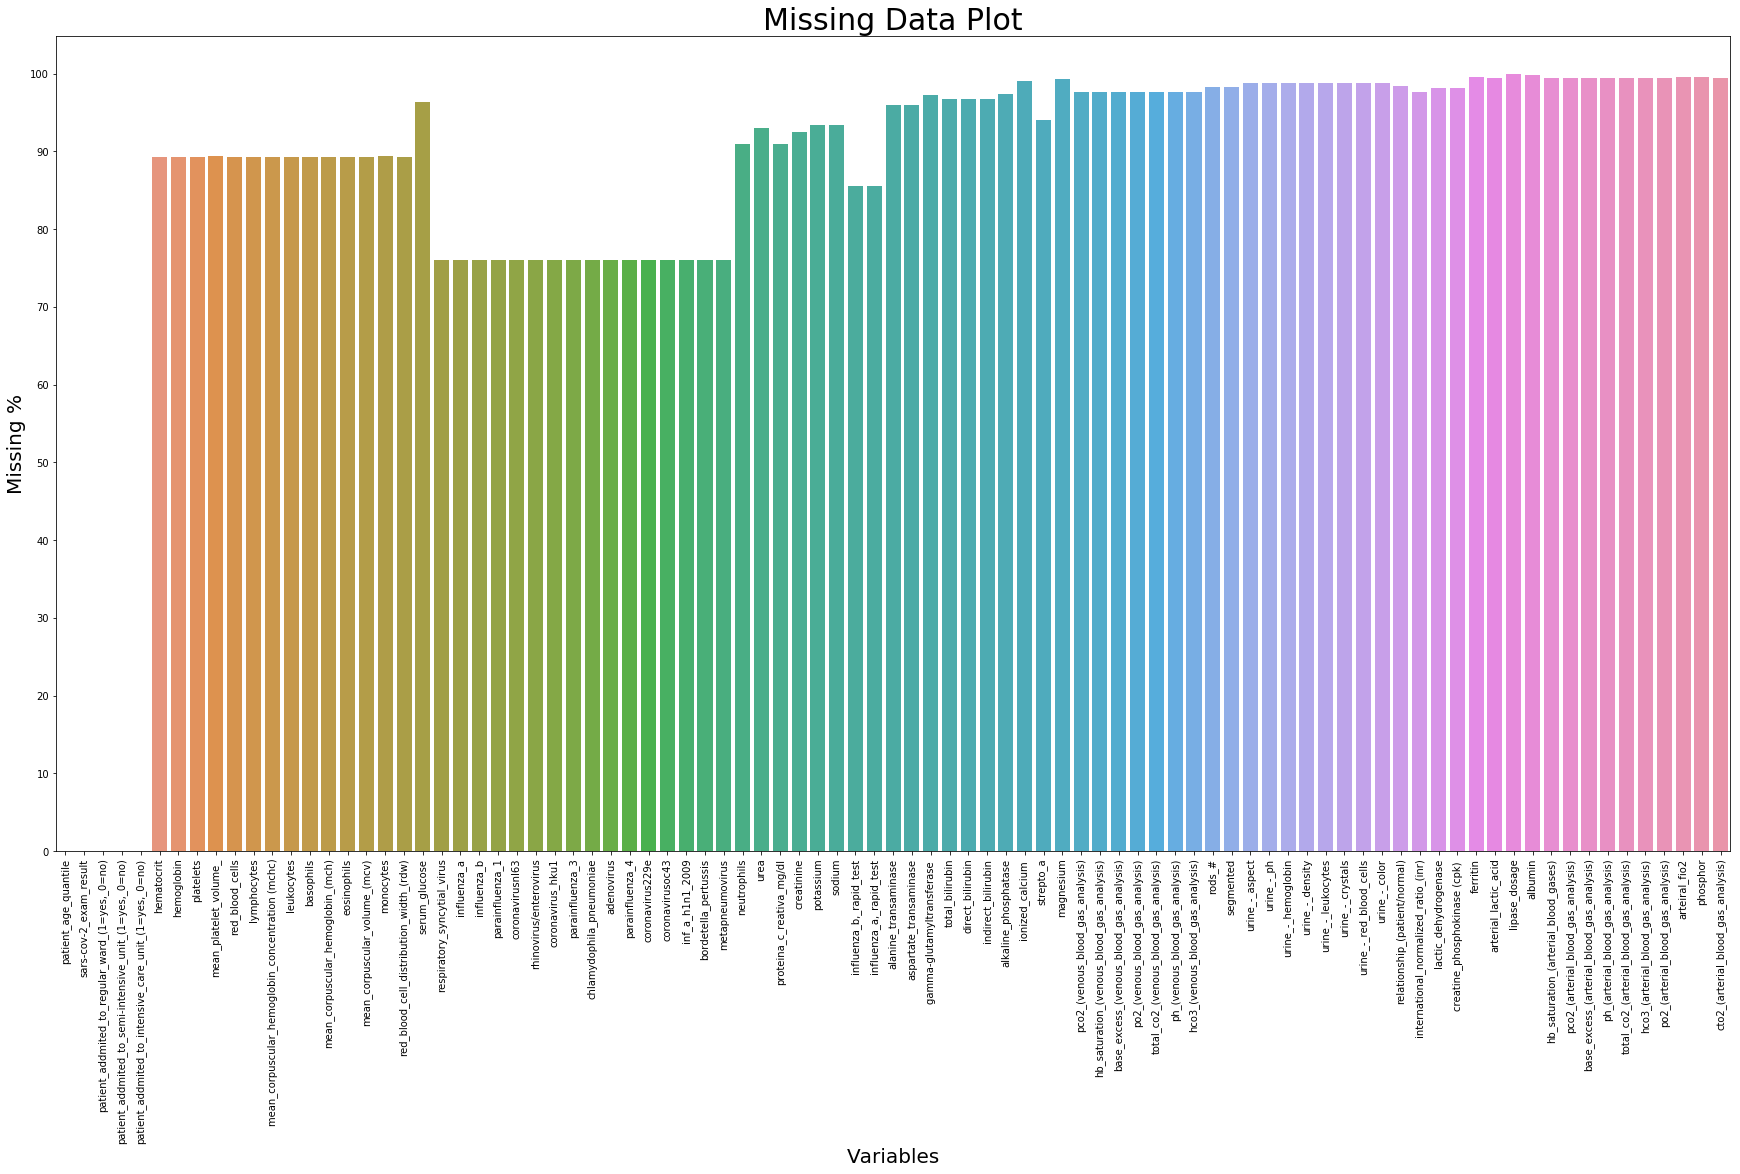

In [14]:
# Plot - % of missing rows for each column
plt.figure(figsize=(30,15))
sns.barplot(x="index", y="nanValuesPct", data=nan_per_column)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Missing %', fontsize=20)
plt.title('Missing Data Plot', fontsize=30)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xticks(rotation=90);

This plot shows that are tons of missing values! Even after my previous cleaning. So before model development, I have to go deeply in this missing analysis, because to develop a model I need a complete dataset to train.

First I have to decide what happens with our NaN values:
- Get only complete samples to my model dataset?
- Impute all missing values?

Well, both solutions are not an option for me right now. The first one probably will select a complete dataset with 0 samples.

In [15]:
len(dataset_raw.dropna(how='any'))

0

The second one: "Impute all missing values" can be complicated. In Missing Data Analysis (field that studies forms to impute a missing information) there are some golden rules (more like recommendations):
- You need to understand if your data is Missing Completely at Random (MCAR), Missing at Random (MAR) or missing Not At Random (MNAR). Imputation methods are only applied for MAR cases.
- Samples with more than 50% missing data should not be imputed
- Columns with more than 40% should not be imputed

First, I will analyze the second and third rules.

### Evaluate: NaN samples [%] > 50% and NaN Columns [%] > 40%

In [16]:
# Print missing pct per column uniques
print(np.unique(nan_per_column['nanValuesPct']))

[ 0.  76.  85.5 89.3 89.4 90.9 91.  92.5 93.  93.4 94.1 96.  96.3 96.8
 97.3 97.4 97.6 98.2 98.3 98.4 98.8 99.1 99.3 99.5 99.6 99.8 99.9]


Based on previous results, **How much features I can keep with follow thresholds (cumulative speaking)?**:
- T1 - features with 76% NaN values
- T2 - features with NaN values between 76% and 90.9%
- T3 - features with NaN values higher than 90.9%

In [17]:
# conters
t1 = 0
t2 = 0
t3 = 0

for i in range(0,len(nan_per_column)):
    if nan_per_column.loc[i, 'nanValuesPct'] <= 76:
        t1 += 1
    elif nan_per_column.loc[i, 'nanValuesPct'] > 76 and nan_per_column.loc[i, 'nanValuesPct'] < 90.9:
        t2 += 1
    elif nan_per_column.loc[i, 'nanValuesPct'] >= 90.9:
        t3 += 1
print('If I keep respectively based in T1, T1+T2, T3 and without threshold: ',t1,t1+t2,t3,t1+t2+t3)

If I keep respectively based in T1, T1+T2, T3 and without threshold:  21 37 52 89


### Before any column NaN filtering threshold, how many rows do I have to impute?

Evaluate rows with less than 50% of missing.

In [18]:
# threshold proposed for features, keep in mind that this dataset have 4 target values
rows_50_threshold = int((len(dataset_raw.columns)-4)/2)

# Eval row limit
print('50% of a sample in this dataset is: ', rows_50_threshold)

50% of a sample in this dataset is:  42


In [19]:
# Before removing
rc = 0
possible_rows = list()
for i in range(0, len(dataset_raw)):
    if dataset_raw.iloc[i].isnull().sum() >= rows_50_threshold:
        rc += 1
    else:
        possible_rows.append(i)
print('Of ', len(dataset_raw), ' total rows, I have ', rc,' rows with more than 50% of missing data, giving a ', len(dataset_raw)-rc,' rows that follows the recommendation for imputation\n')

# Number of columns with at least 10% of missing data to impute (being generous)
df_aux = dataset_raw.loc[possible_rows]
miss_less_10 = 0
for c in dataset_raw.columns:
    if (df_aux[c].isna().sum()/len(possible_rows)) == 0.0:
        pass
    elif (df_aux[c].isna().sum()/len(possible_rows)) < 0.10:
        miss_less_10 += 1
        print(c, 'with ',df_aux[c].isna().sum(),' of missing data could be imputed')

# Case proportions
print('\n\nPositive samples: ', sum(df_aux['sars-cov-2_exam_result'] == 'positive'),' and Negative samples:', sum(df_aux['sars-cov-2_exam_result'] == 'negative'), 
      ' - proportion [%]: ', round(100*sum(df_aux['sars-cov-2_exam_result'] == 'positive')/len(df_aux),2))

Of  5644  total rows, I have  5474  rows with more than 50% of missing data, giving a  170  rows that follows the recommendation for imputation

mean_platelet_volume_ with  1  of missing data could be imputed
monocytes with  1  of missing data could be imputed
respiratory_syncytial_virus with  3  of missing data could be imputed
influenza_a with  3  of missing data could be imputed
influenza_b with  3  of missing data could be imputed
parainfluenza_1 with  3  of missing data could be imputed
coronavirusnl63 with  3  of missing data could be imputed
rhinovirus/enterovirus with  3  of missing data could be imputed
coronavirus_hku1 with  3  of missing data could be imputed
parainfluenza_3 with  3  of missing data could be imputed
chlamydophila_pneumoniae with  3  of missing data could be imputed
adenovirus with  3  of missing data could be imputed
parainfluenza_4 with  3  of missing data could be imputed
coronavirus229e with  3  of missing data could be imputed
coronavirusoc43 with  3  of

### Filter I: Remove 51 columns that have NaN values > T3 and verify samples quantity

In [20]:
# Possible variables to keep
cols_to_keep = list()
for i in range(0,len(nan_per_column)):
    if nan_per_column.loc[i, 'nanValuesPct'] < 90.9:
        cols_to_keep.append(nan_per_column.loc[i,'index'])
# Print how many variables I will keep  
print('Filter 1 - columns: ', len(cols_to_keep))

Filter 1 - columns:  37


In [21]:

# Creating a aux dataframe with filtered columns, keeping control over raw dataset
df_aux = dataset_raw[cols_to_keep]
# Eval limit
rows_50_threshold = int((len(df_aux.columns)-4)/2)
print('50% of a sample in this dataset is: ', rows_50_threshold)

50% of a sample in this dataset is:  16


In [22]:
# Threshold T1 + T2 applying...
rc = 0
possible_rows = list()
for i in range(0, len(df_aux)):
    if df_aux.iloc[i].isnull().sum() >= rows_50_threshold:
        rc += 1
    else:
        possible_rows.append(i)
print('Of ', len(df_aux), ' total rows, I have ', rc,' rows with more than 50% of missing data, giving a ', len(df_aux)-rc,' rows that follows the recommendation for imputation\n')
# Number of columns with at least 10% of missing data to impute (being generous)
df_aux = df_aux.loc[possible_rows]
miss_less_15 = 0
for c in df_aux.columns:
    if (df_aux[c].isna().sum()/len(possible_rows)) == 0.0:
        pass
    elif (df_aux[c].isna().sum()/len(possible_rows)) < 0.10:
        miss_less_15 += 1
        print(c, 'with ',df_aux[c].isna().sum(),' of missing data could be imputed')
# Case proportions
print('\n\nPositive samples: ', sum(df_aux['sars-cov-2_exam_result'] == 'positive'),' and Negative samples:', sum(df_aux['sars-cov-2_exam_result'] == 'negative'), 
      ' - proportion: ', round(100*sum(df_aux['sars-cov-2_exam_result'] == 'positive')/len(df_aux),2))

Of  5644  total rows, I have  5112  rows with more than 50% of missing data, giving a  532  rows that follows the recommendation for imputation



Positive samples:  58  and Negative samples: 474  - proportion:  10.9


Using those results I can have a possible dataset with only 532 rows, but more consistent and less sparse.

In [23]:
# Renaming df
dataset = df_aux
dataset.index = range(0,len(dataset))

### How many complete rows do I have in this filtered dataset?

In [24]:
# Counter
rc = 0
# Loop to verify complete rows
for i in range(0, len(dataset)):
    if dataset.iloc[i].isnull().sum() == 0.0:
        rc += 1
print('complete rows: ', rc)

complete rows:  99


### Verify that after this filter, any discrete variable become static (no variance):

In [25]:
# Verify categorical columns after dropping
cat_vars = list()
for j in dataset.columns:
    if len(dataset[j].unique()) <= 5:
        cat_vars.append(j)
print('This dataset have now',len(cat_vars), ' categorical variables of ',len(dataset),'\n')

for c in cat_vars:
    print(c, ' - ', dataset[c].unique())

This dataset have now 22  categorical variables of  532 

sars-cov-2_exam_result  -  ['negative' 'positive']
patient_addmited_to_regular_ward_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_intensive_care_unit_(1=yes,_0=no)  -  [0 1]
respiratory_syncytial_virus  -  ['not_detected' 'detected']
influenza_a  -  ['not_detected' 'detected']
influenza_b  -  ['not_detected' 'detected']
parainfluenza_1  -  ['not_detected' 'detected']
coronavirusnl63  -  ['not_detected' 'detected']
rhinovirus/enterovirus  -  ['detected' 'not_detected']
coronavirus_hku1  -  ['not_detected' 'detected']
parainfluenza_3  -  ['not_detected' 'detected']
chlamydophila_pneumoniae  -  ['not_detected' 'detected']
adenovirus  -  ['not_detected' 'detected']
parainfluenza_4  -  ['not_detected' 'detected']
coronavirus229e  -  ['not_detected' 'detected']
coronavirusoc43  -  ['not_detected' 'detected']
inf_a_h1n1_2009  -  ['not_detected' 'detected']
bordetella_pertuss

Everyone except ```bordetella_pertussis``` have a binary nature, so let's remove it!

In [26]:
dataset.drop('bordetella_pertussis', axis=1, inplace=True)

# Data assumptions - a biological assessment to reduce missing values and data complexity

Given the fact that our final dataset got some categorical variables related to: **detected or not** a type of virus/bacteria, let's insert some **assumptions** for features
- respiratory_syncytial_virus
- influenza_a 
- influenza_b
- parainfluenza_1
- coronavirusnl63
- rhinovirus/enterovirus
- coronavirus_hku1
- parainfluenza_3
- chlamydophila_pneumoniae
- adenovirus
- parainfluenza_4
- coronavirus229e
- coronavirusoc43 
- inf_a_h1n1_2009
- bordetella_pertussis
- metapneumovirus
- influenza_b,_rapid_test
- influenza_a,_rapid_test


## Assumptions

- **Assumption 1**: They are here, because somehow they could influence in some respiratory disease
- **Assumption 2**: Probably, ```influenza_a,_rapid_test``` and ```influenza_b,_rapid_test``` have the same results respectively for ```influenza_a``` and ```influenza_b```. So they need to become only two columns.
- **Assumption 3**: I will combine those features in one column based in **Taxonomy Genus group**. The generic coluns will be binary where 1 means **have any of this Genus** and 0 means **got none of this Genus**.


**PS 1**: Would exist an fourth assumption that given a biological background and **Assumption 1** I would combine the species related to **Bacterias** Kingdom in one column (based on the fact that I dropped this column it is not necessary).

**PS 2**: Got this idea after a commentary by [Lucas Moda](https://www.kaggle.com/lukmoda)

The image bellow shows a taxonomy pyramid:

![gen](https://user-images.githubusercontent.com/32513366/78076320-93bd0a00-737c-11ea-881d-b9af626e86a2.jpg)

[Image source](https://www.tes.com/lessons/cZH2FUDnGVZvyg/classification-11)



## Changing discrete values: negative/not_detect becomes 0 and positive/detected becomes 1

In [27]:
# Verify categorical columns after dropping
cat_vars = list()
for j in dataset.columns:
    if len(dataset[j].unique()) <= 5:
        cat_vars.append(j)

In [28]:
# Changing string values to 
for j in cat_vars:
    if 'positive' in list(dataset[j].unique()):
        dataset[j].replace('positive',1, inplace=True)
    elif 'detected' in list(dataset[j].unique()):
        dataset[j].replace('detected',1, inplace=True)
    if 'negative' in list(dataset[j].unique()):
        dataset[j].replace('negative',0, inplace=True) 
    elif 'not_detected' in list(dataset[j].unique()):
        dataset[j].replace('not_detected',0, inplace=True)

In [29]:
# Verify categorical columns after dropping
cat_vars = list()
for j in dataset.columns:
    if len(dataset[j].unique()) <= 5:
        cat_vars.append(j)
print('This dataset have now',len(cat_vars), ' categorical variables of ',len(dataset),'\n')

# Print results
for c in cat_vars:
    print(c, ' - ', dataset[c].unique())

This dataset have now 21  categorical variables of  532 

sars-cov-2_exam_result  -  [0 1]
patient_addmited_to_regular_ward_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_intensive_care_unit_(1=yes,_0=no)  -  [0 1]
respiratory_syncytial_virus  -  [0 1]
influenza_a  -  [0 1]
influenza_b  -  [0 1]
parainfluenza_1  -  [0 1]
coronavirusnl63  -  [0 1]
rhinovirus/enterovirus  -  [1 0]
coronavirus_hku1  -  [0 1]
parainfluenza_3  -  [0 1]
chlamydophila_pneumoniae  -  [0 1]
adenovirus  -  [0 1]
parainfluenza_4  -  [0 1]
coronavirus229e  -  [0 1]
coronavirusoc43  -  [0 1]
inf_a_h1n1_2009  -  [0 1]
metapneumovirus  -  [0 1]
influenza_b,_rapid_test  -  [ 0. nan  1.]
influenza_a,_rapid_test  -  [ 0. nan  1.]


## Assumption 2

In [30]:
# If a value is
for i in range(0, len(dataset)):
    if pd.isna(dataset.loc[i, 'influenza_a,_rapid_test']) is False and pd.isna(dataset.loc[i, 'influenza_a']) is False:
        if dataset.loc[i, 'influenza_a,_rapid_test'] != dataset.loc[i, 'influenza_a']:
            print(i, 'sample have different for influenza A: ',dataset.loc[i, 'influenza_a'],' and test A: ', dataset.loc[i, 'influenza_a,_rapid_test'])
    if pd.isna(dataset.loc[i, 'influenza_b,_rapid_test']) is False and pd.isna(dataset.loc[i, 'influenza_b']) is False:    
        if dataset.loc[i, 'influenza_b,_rapid_test'] != dataset.loc[i, 'influenza_b']:
            print(i, 'sample have different for influenza B: ',dataset.loc[i, 'influenza_b'],' and test B: ', dataset.loc[i, 'influenza_b,_rapid_test'])
    

2 sample have different for influenza A:  0  and test A:  1.0
7 sample have different for influenza B:  1  and test B:  0.0
16 sample have different for influenza A:  0  and test A:  1.0
17 sample have different for influenza A:  1  and test A:  0.0
45 sample have different for influenza B:  1  and test B:  0.0
56 sample have different for influenza B:  1  and test B:  0.0
81 sample have different for influenza A:  0  and test A:  1.0
91 sample have different for influenza B:  1  and test B:  0.0
102 sample have different for influenza A:  0  and test A:  1.0
112 sample have different for influenza B:  1  and test B:  0.0
124 sample have different for influenza A:  1  and test A:  0.0
126 sample have different for influenza B:  1  and test B:  0.0
136 sample have different for influenza A:  0  and test A:  1.0
148 sample have different for influenza A:  0  and test A:  1.0
162 sample have different for influenza A:  0  and test A:  1.0
163 sample have different for influenza B:  1  and

### Arguments to keep rapid test from this dataset
- Divergent columns for both influenza types, so it's different collumns

### Arguments to remove rapid test from this dataset
- After a small research in [reference 1](https://en.wikipedia.org/wiki/Rapid_influenza_diagnostic_test#cite_note-pmid20409373-6), I verified that **influenza rapid test** is a fast way to diagnose antigen presence, technically the same results for ```influenza_a``` and ```influenza_b```.
- Reading [reference 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2954007/) I verified that some papers presents those rapid tests as not confident at all, they mention that in outbreak situations would not be recommended for example (now we are living a outbreak).
- Based in [reference 3](https://www.cdc.gov/mmwr/preview/mmwrhtml/mm5830a2.htm) depending on test type, it can be reliable or not 

### Assumption 2 - Conclusion
Given the lack of confidence in these rapid test variables I assume that ```influenza_a``` or ```influenza_b``` are more reliable and given the fact that they can be considerated the same:**I will remove those features**

In [31]:
# Dropping rapid test columns
dataset.drop(['influenza_a,_rapid_test', 'influenza_b,_rapid_test'], axis=1, inplace=True)

## Assumption 1
Based in **Wikipedia pages** refered to those virus/bacterias, I present the **Family Taxonomy** for each virus/bacteria in this dataset (after the filter):

![image](https://user-images.githubusercontent.com/32513366/78080117-efd75c80-7383-11ea-93b5-976d1cd4f328.png)

I will create a new column for each family, grouping species:
- detection_adenoviridae
- detection_coronaviridae
- detection_orthomyxoviridae
- detection_paramyxoviridae
- detection_picornaviridae
- detection_pneumoviridae

This procedure will: Decrease model's possible complexity from 14 features to 6 features and probably remove missing values given the family taxonomy approach

In [32]:
# Defining lists for each family column
detection_adenoviridae = ['adenovirus']
detection_coronaviridae = ['coronavirusoc43', 'coronavirus_hku1', 'coronavirusnl63', 'coronavirus229e']
detection_orthomyxoviridae = ['influenza_a', 'influenza_b', 'inf_a_h1n1_2009'] 
detection_paramyxoviridae = ['parainfluenza_1', 'parainfluenza_3', 'parainfluenza_4']
detection_picornaviridae = ['rhinovirus/enterovirus']
detection_pneumoviridae = ['respiratory_syncytial_virus', 'metapneumovirus']
groups_list = [detection_adenoviridae, detection_coronaviridae, detection_orthomyxoviridae, detection_paramyxoviridae, detection_picornaviridae, detection_pneumoviridae]
groups_cols = ['detection_adenoviridae', 'detection_coronaviridae', 'detection_orthomyxoviridae', 'detection_paramyxoviridae', 'detection_picornaviridae', 'detection_pneumoviridae']

# Create the new columns 
for family_group,family_col in zip(groups_list, groups_cols):
    for i in range(0, len(dataset)):
        for j in family_group:
            if pd.isna(dataset.loc[i, j]) is False: # If it's nan can crash the comparison
                if dataset.loc[i, j] == 1: # I need only one column to say if will be a 1 (family detection)
                    dataset.loc[i,family_col] = 1
                    break
                else:
                    dataset.loc[i,family_col] = 0

In [33]:
# Dropping old species columns
drop_species_cols = detection_adenoviridae + detection_coronaviridae + detection_orthomyxoviridae + detection_paramyxoviridae + detection_picornaviridae + detection_pneumoviridae
dataset.drop(drop_species_cols, inplace=True, axis=1)

In [34]:
# Verify if new columns are statical features
cat_vars = list()
for j in dataset.columns:
    if len(dataset[j].unique()) <= 5:
        print(j, ' - ', dataset[j].unique())
        cat_vars.append(j)
print('This dataset have now',len(cat_vars), ' discrete variables of ',len(dataset),'\n')

sars-cov-2_exam_result  -  [0 1]
patient_addmited_to_regular_ward_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)  -  [0 1]
patient_addmited_to_intensive_care_unit_(1=yes,_0=no)  -  [0 1]
chlamydophila_pneumoniae  -  [0 1]
detection_adenoviridae  -  [0. 1.]
detection_coronaviridae  -  [0. 1.]
detection_orthomyxoviridae  -  [0. 1.]
detection_paramyxoviridae  -  [0. 1.]
detection_picornaviridae  -  [1. 0.]
detection_pneumoviridae  -  [0. 1.]
This dataset have now 11  discrete variables of  532 



## Standardization

Given the fact that I massively reduce the original dataset, for precaution I will apply a standardization.


In [36]:
# Num features
num_features = ['hematocrit',
                'hemoglobin',
                'platelets',
                'mean_platelet_volume_',
                'red_blood_cells',
                'lymphocytes',
                'mean_corpuscular_hemoglobin_concentration\xa0(mchc)',
                'leukocytes',
                'basophils',
                'mean_corpuscular_hemoglobin_(mch)',
                'eosinophils',
                'mean_corpuscular_volume_(mcv)',
                'monocytes',
                'red_blood_cell_distribution_width_(rdw)']
# scaler object
scaler = StandardScaler()
dataset[num_features] = scaler.fit_transform(dataset[num_features])

## Eval missing samples for each column again

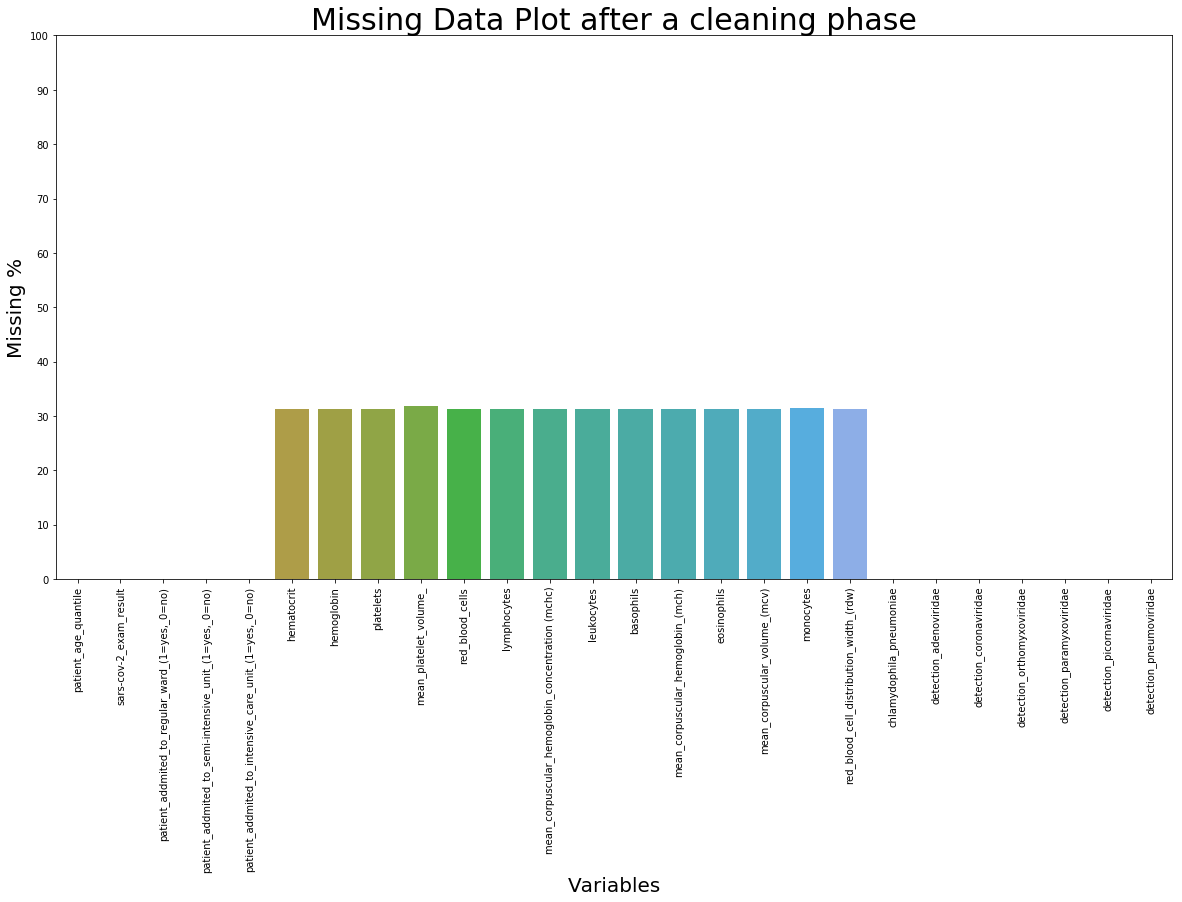

In [37]:
# Eval missing value for each column again
nan_per_column = pd.DataFrame(dataset.isna().sum(),columns=['nanValues']).reset_index()

# Calculate NaN %
for i in range(0,len(nan_per_column)):
    nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(dataset),3)
    
# Plot - % of missing rows for each column
plt.figure(figsize=(20,10))
sns.barplot(x="index", y="nanValuesPct", data=nan_per_column)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Missing %', fontsize=20)
plt.title('Missing Data Plot after a cleaning phase', fontsize=30)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xticks(rotation=90);

### Phase Conclusion

**Well, now we got a better missing perspective view!**

I had to make a trade: lost tons of rows, more than 90% of my original dataset. But this is Ok! It's important to have confidence in your dataset before any model development.

# Impute or Not Impute? that is the question

Now I have a decision to make:
- A - Work with a complete dataset, dropping any NaN samples
- B - Impute missing data

Let's evaluate both separately. But first I will present my knowledge over some imputation practices:
- Doing Average imputation you may be generalizing negative cases into positive cases, which can be considered an medical error. Even because, how can you extrapolate the values of a positive case only with values for negative cases?
- Initially, this dataset have a great amount of missing values, imputation for 90% missing sample are not recommended at all!
- I cleaned initially 21 static variables, a zero imputation without any data understand would input a useless feature into your model.
- At all, it's not recommendate simple imputation.
- Even through a Selected Case Average imputation (imputing negative cases with negative cases average and positive cases with positive cases average) can cause two problems such as: lack of a considerable samples (mainly for positive cases) to propose a representative average  or situations where positive cases do not even present samples to take the average.
- Besides that Mean imputation or Zero imputation are not recommended given the diversity of imputation techniques in this field.
- Even if your model have an accuracy/recall of 90%, you really need to have confidence over your trainset.

Now, Let's go back and analyze deeply this NaN cases matter to impute, now splitting the dataset.

## Work with a complete dataset

### What is the number of rows in this complete dataset?

In [38]:
# Drop any NaN sample, creating a copy of my dataset
dataset_complete = dataset.dropna(how='any').copy()
dataset_complete.index = range(0, len(dataset_complete.index))

# Show number of rows
print('Complete rows: ', len(dataset_complete), '| Keeped % rows:',100*round(len(dataset_complete)/len(dataset),2))

Complete rows:  362 | Keeped % rows: 68.0


Based in this result, I verify that I lost 32% of my samples. 

### What is the number of positive/negative cases in this complete dataset?

In [39]:
print('Positive cases: ', sum(dataset_complete['sars-cov-2_exam_result'] == 1),' | Negative cases: ', sum(dataset_complete['sars-cov-2_exam_result'] == 0),'\n###')
print('Previous Positive cases: ', sum(dataset['sars-cov-2_exam_result'] == 1), ' | Keeped % for Positive cases: ',
      100*round(sum(dataset_complete['sars-cov-2_exam_result'] == 1)/sum(dataset['sars-cov-2_exam_result'] == 1), 2))

Positive cases:  50  | Negative cases:  312 
###
Previous Positive cases:  58  | Keeped % for Positive cases:  86.0


Not bad at all, given the fact that I lost more negative cases could be a good sign, because this situation decrease **imbalanced label problem**...

## Impute missing data

Before any analysis or imputation, it's necessary to understand the missing types. From [reference 4](https://www.theanalysisfactor.com/missing-data-mechanism/):
- **Missing Completely at Random (MCAR)**: there is NO relationship between the missingness of the data and any values, observed or missing. Those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than others.
- **Missing at Random (MAR)**: there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data. Whether an observation is missing has nothing to do with the missing values, but it does have to do with the values of an individual’s observed variables.
- **Missing Not at Random (MNAR)**: there is a relationship between the propensity of a value to be missing and its values. This is a case where the people with the lowest education are missing on education or the sickest people are most likely to drop out of the study. MNAR is called “non-ignorable” because the missing data mechanism itself has to be modeled as you deal with the missing data. You have to include some model for why the data are missing and what the likely values are.

Given those definitions, I present a pipeline from [reference 5](https://towardsdatascience.com/missing-data-cfd9dbfd11b7):
![maPipe](https://user-images.githubusercontent.com/32513366/78101044-a6573380-73bc-11ea-97bc-4453b4d210a3.png)

Basically, to do any imputation I need to evaluate if my missing values are **MAR**. This statement is based in [reference 6](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-017-0442-1) (a really good paper that explain step by step how to do a complete missing data study).

To eval MNAR vs MAR vs MCAR is very subjective... There isn't any developed test to verify this, so will be necessary some qualitative study with some plots through ```missingno``` module.

### MNAR vs MAR vs MCAR - Nullity Matrix
This plot shows as **black** observed data and **white** as NaN value.

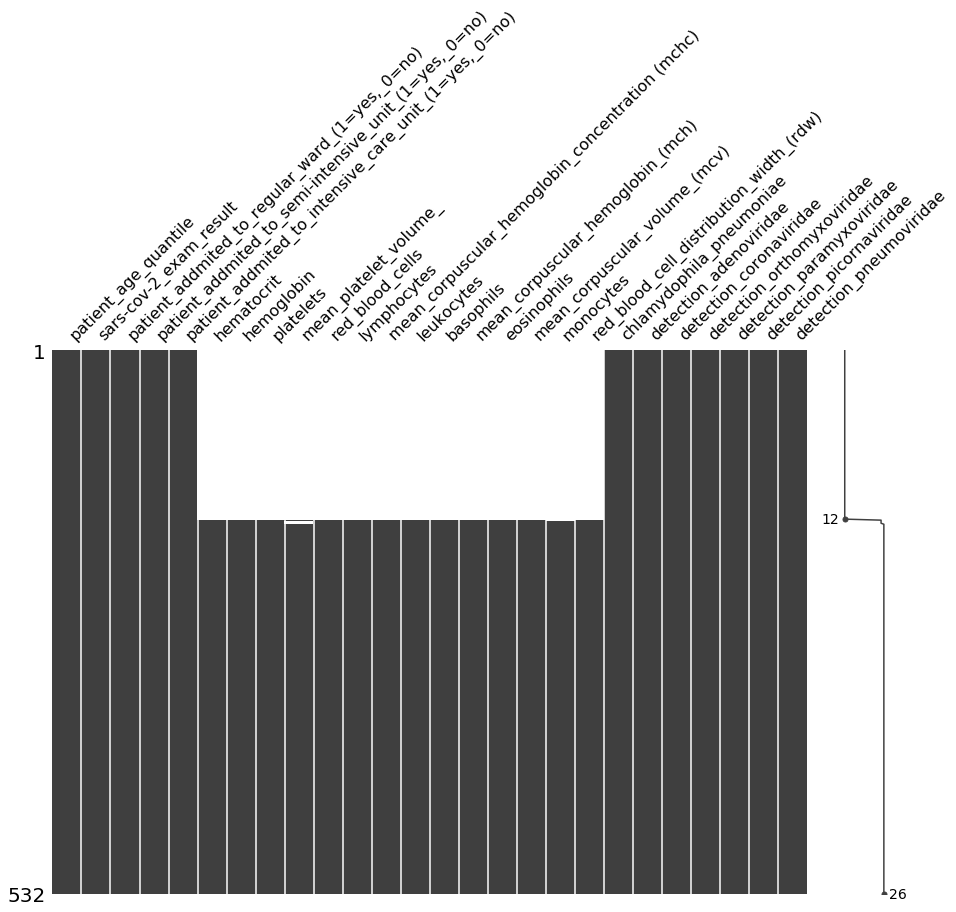

In [40]:
# Nullity Matrix
msno.matrix(dataset, sort='ascending', figsize=(15, 10));

Based in [reference 7](http://terra-datasystems.com/missing-data-analysis.html) and [reference 8](https://www.kaggle.com/drewheasman/missingness-analysis), both from the same author, and [reference 9](https://s3.amazonaws.com/assets.datacamp.com/production/course_17404/slides/chapter2.pdf) This result shows that my dataset is definitely **not** a MCAR missing type given the lack of missing randomness.

The heatmap plot increase this answer:

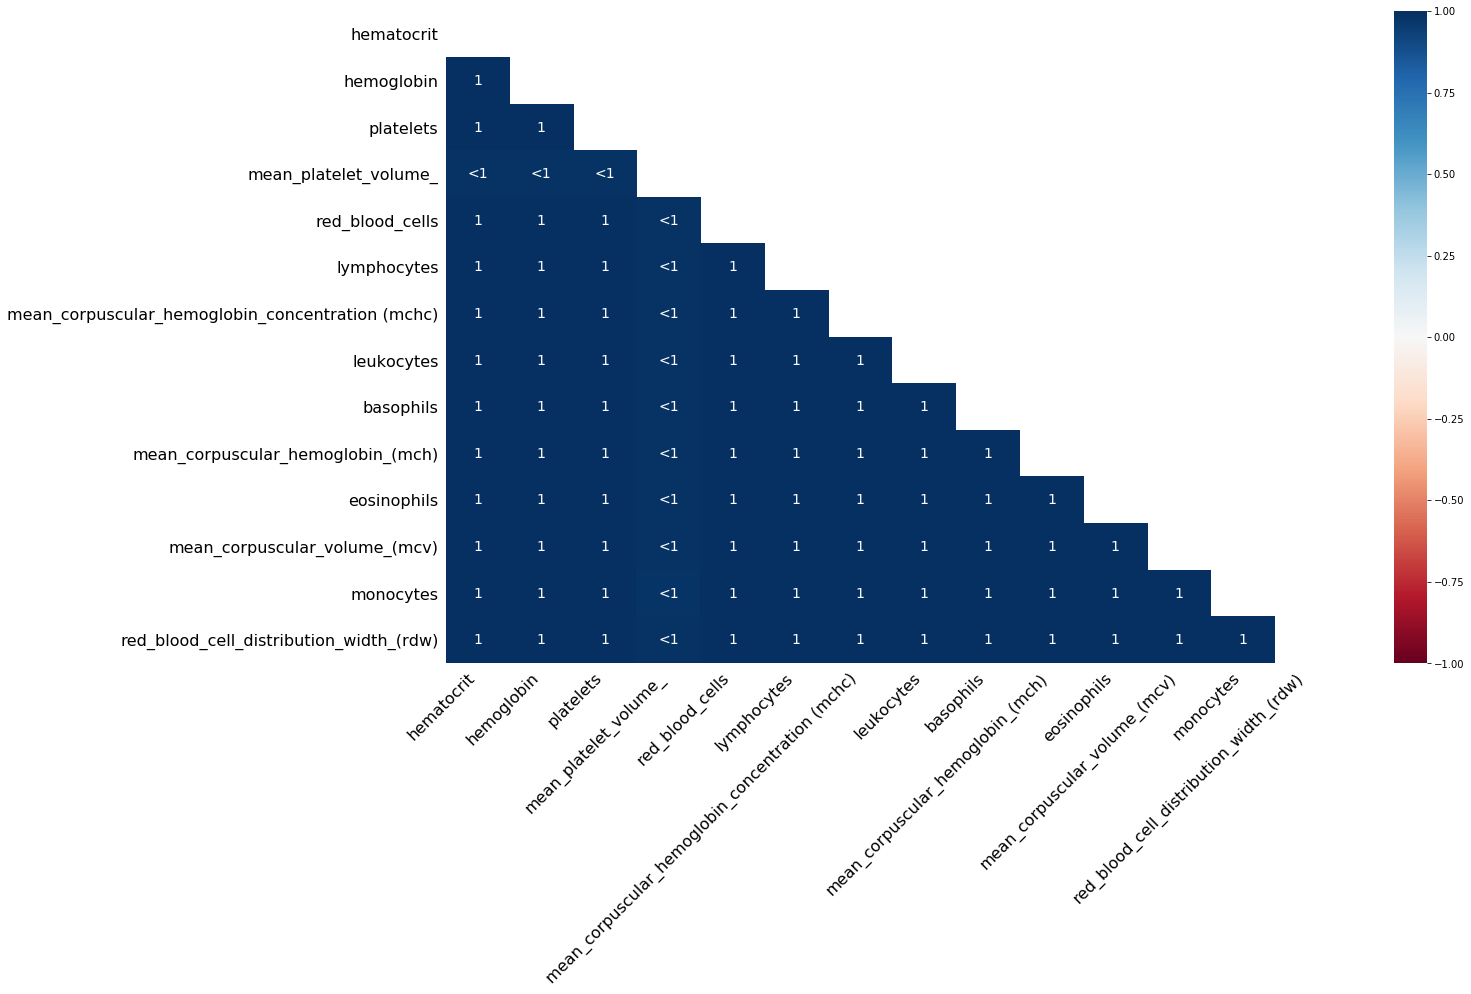

In [41]:
# Heatmap plot
msno.heatmap(dataset);

For a better understandment of those graphs, look at [reference 10](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87).
### MNAR vs MAR
This is a subjective analysis. Given the fact that a **MNAR** classification depends exclusively from Hospital Albert Einstein. For example, I cannot assume that those samples were missing because a doctor/nurse mistake or lack of measuring device. Given the nullity matrix and the heatmap I assume that my missing samples are **MAR** type. This allowsme to finally do some imputation.

From [reference 6](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-017-0442-1) to impute any data it's necessary to pass this pipeline:

![image](https://user-images.githubusercontent.com/32513366/78102793-9130d380-73c1-11ea-94fc-ca775fdb61ba.png)

Checking the boxes:
- **Is it valid to ignore missing data (<5%)?**

**NO**, given the fact that I will lose 32% of my samples.

- **Too large proportions of missing data for each column (>40%)?**

**NO**, considering that each variable have less than 40% of missing data (reading this paper, it's implicit that the author talks about the variable individualy).

PS: Now you can see where I got one of my golden rules...

- **It's data only missing on dependent variable (target)?**

**NO**, my targets are complete!

- **Is the MCAR assumption plausible?**

**NO**, nullity matrix and heatmap explained this.

- **Is the MNAR assumption plausible?**

**NO**, as I said previously: based in MNAR definition, only the Hospital could define it.

## MICE imputation

In [42]:
# Create a copy of my original dataset
dataset_impute = dataset.copy()

In [44]:
# Apply MICE
dataset_impute_complete = MICE(max_iter=100, verbose=1, random_state=1206).fit_transform(dataset_impute.values)

# Turning into df again
dataset_impute = pd.DataFrame(data=dataset_impute_complete, columns=dataset_impute.columns, index=dataset_impute.index)

[IterativeImputer] Completing matrix with shape (532, 26)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.019 
[IterativeImputer] Early stopping criterion reached.


Given the stopping criterion success and previous arguments during missing analysis, I will continue my study with imputed dataset!

## Creating separate datasets for each task (changing only target variable)

In [46]:
# Create a copy of choice dataset
dataset_choice = dataset_impute.copy()

In [47]:
# Data Task 1
dataset_task1 = dataset_choice.drop(['patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)',
                                       'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)',
                                       'patient_addmited_to_regular_ward_(1=yes,_0=no)'], axis=1)
# Data Task 2
dataset_task2 = dataset_choice.drop(['sars-cov-2_exam_result'], axis=1)

In [50]:
# Create a new unique target column for Task 2
targets_task2 = ['patient_addmited_to_regular_ward_(1=yes,_0=no)',
                 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)',
                 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']

## Evaluate the number of possibilities for three targets in a single column
patient_addmited_possibilities = list()
for i in range(0, len(dataset_task2)):
    possibility=str(int(dataset_task2.loc[i,targets_task2[0]])) + str(int(dataset_task2.loc[i,targets_task2[1]])) + str(int(dataset_task2.loc[i,targets_task2[2]]))
    patient_addmited_possibilities.append(possibility)

## Print result
print(sorted(set(patient_addmited_possibilities)))

['000', '001', '010', '100']


I will assume for task 2:
- Category 0 implies not addmited ('000')
- Category 1 implies regular ward ('100')
- Category 2 implies semi-intensitve unit ('010')
- Category 3 implies intensitve care unit ('001')

In [51]:
## Create the new column
dataset_task2['patient_addmited_cats'] = patient_addmited_possibilities

## Change the new column to num values
for i in range(0, len(dataset_task2)):
    if dataset_task2.loc[i, 'patient_addmited_cats'] == '000':
        dataset_task2.loc[i, 'patient_addmited_cats'] = 0
    elif dataset_task2.loc[i, 'patient_addmited_cats'] == '100':
        dataset_task2.loc[i, 'patient_addmited_cats'] = 1
    elif dataset_task2.loc[i, 'patient_addmited_cats'] == '010':
        dataset_task2.loc[i, 'patient_addmited_cats'] = 2
    elif dataset_task2.loc[i, 'patient_addmited_cats'] == '001':
        dataset_task2.loc[i, 'patient_addmited_cats'] = 3
## See class distribution
dataset_task2['patient_addmited_cats'].value_counts()

0    419
1     48
2     39
3     26
Name: patient_addmited_cats, dtype: int64

Again, task two will be a imbalanced problem to solve...

In [52]:
# Drop residual cols in task 2 dataset
dataset_task2.drop(targets_task2, axis=1, inplace=True)

In [53]:
# Create list of feature columns for each dataset
features = list(dataset_task1.drop(['sars-cov-2_exam_result'], axis=1).columns)

In [54]:
# Separate numerical columns from cat columns to help some plots
num_features = ['hematocrit',
                'hemoglobin',
                'platelets',
                'mean_platelet_volume_',
                'red_blood_cells',
                'lymphocytes',
                'mean_corpuscular_hemoglobin_concentration\xa0(mchc)',
                'leukocytes',
                'basophils',
                'mean_corpuscular_hemoglobin_(mch)',
                'eosinophils',
                'mean_corpuscular_volume_(mcv)',
                'monocytes',
                'red_blood_cell_distribution_width_(rdw)']

cat_features = ['patient_age_quantile',
                'chlamydophila_pneumoniae',
                'detection_adenoviridae',
                'detection_coronaviridae',
                'detection_orthomyxoviridae',
                'detection_paramyxoviridae',
                'detection_picornaviridae',
                'detection_pneumoviridae']

# Exploratory Data Analysis

## Eval COVID positive samples proportion

In [55]:
# Eval 'sars-cov-2_exam_result' proportions
print('Positive case proportion - original dataset [%]: ', round(100*dataset_raw['sars-cov-2_exam_result'].value_counts()[1]/dataset_raw['sars-cov-2_exam_result'].value_counts().sum(),2))
print('Positive case proportion - complete dataset [%]: ', round(100*dataset_complete['sars-cov-2_exam_result'].value_counts()[1]/dataset_complete['sars-cov-2_exam_result'].value_counts().sum(),2))

Positive case proportion - original dataset [%]:  9.89
Positive case proportion - complete dataset [%]:  13.81


Given the fact that the original proportion was tresspassed, It's possible to say that I reduced imbalanced data a little bit (being optimistic).

## Pairplot for numerical features

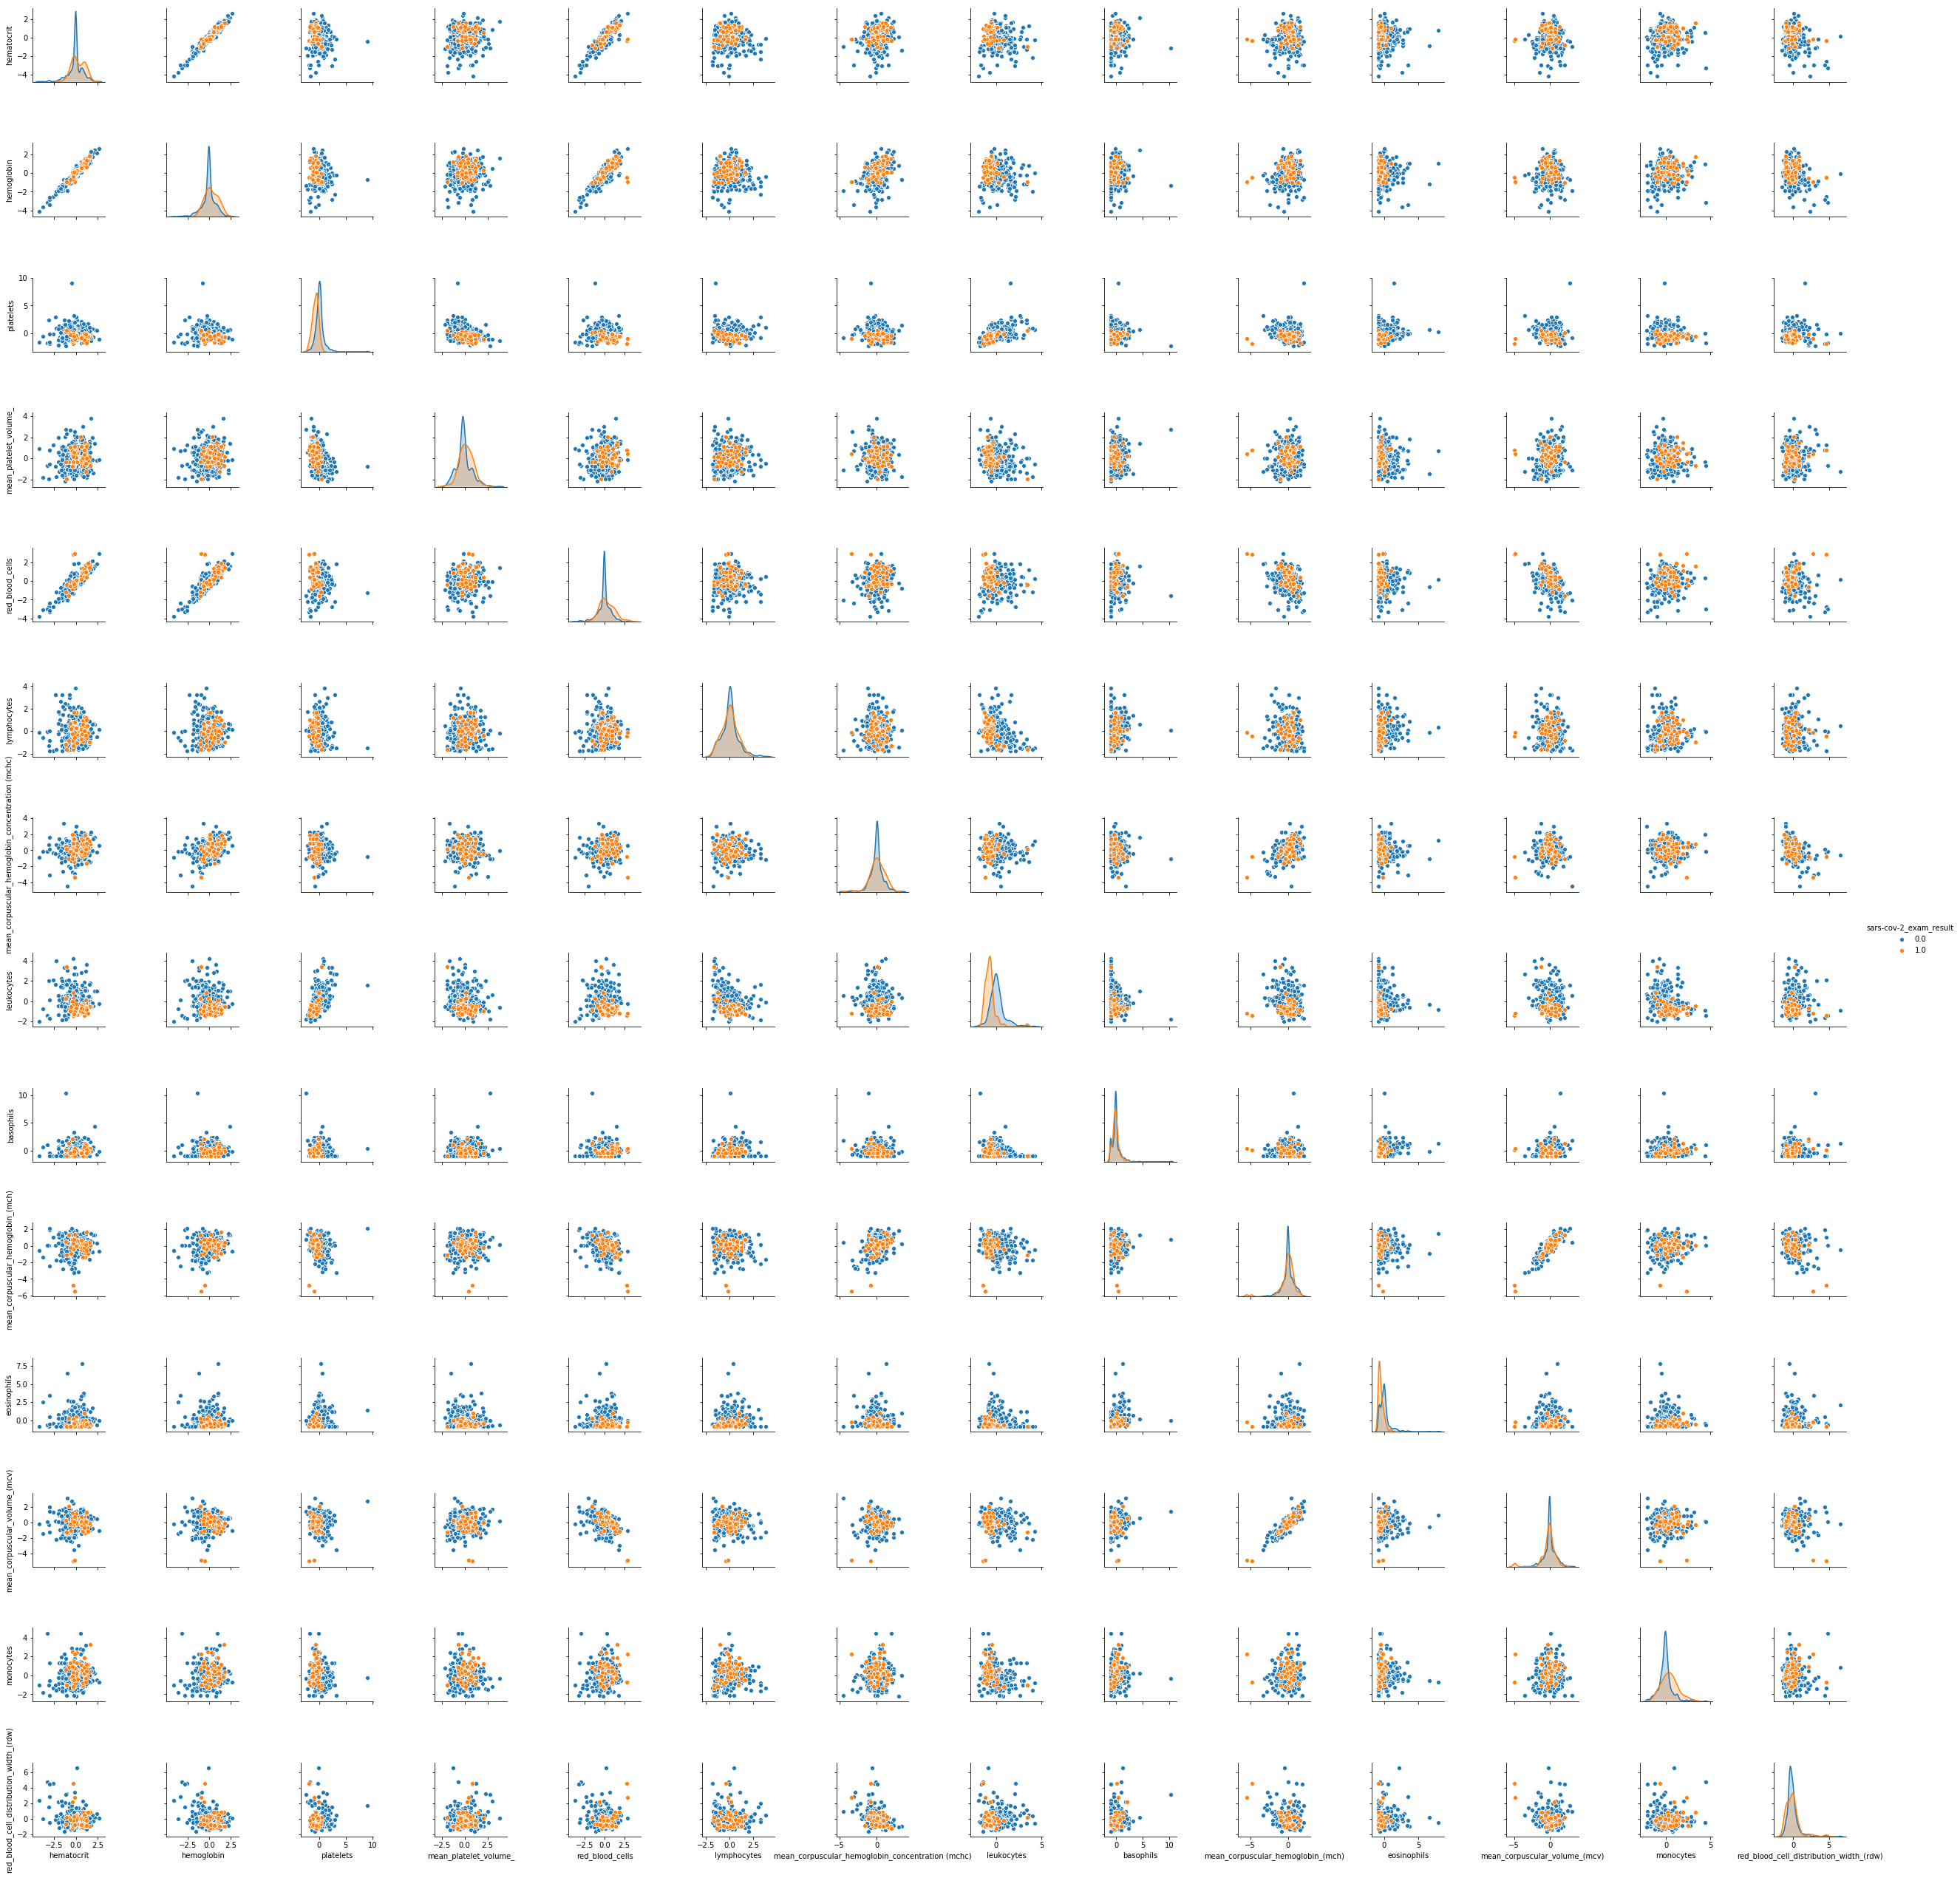

In [56]:
sns.pairplot(dataset_task1[['sars-cov-2_exam_result']+num_features], hue='sars-cov-2_exam_result');

Through this amount of plots, it's possible to see that some variables are highly correlated. Let's evaluate this through a correlation heatmap.

## Correlation Heatmap for numerical features

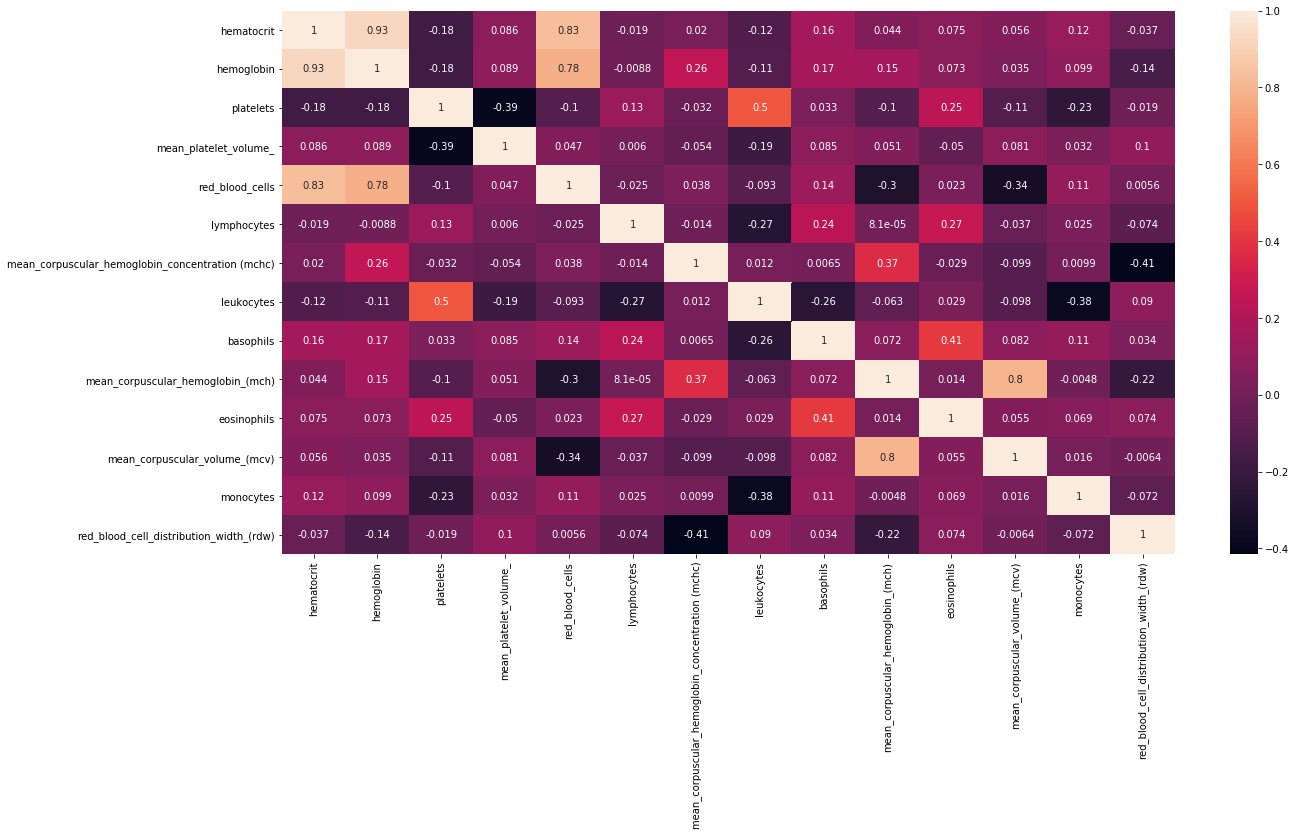

In [57]:
# Correlation calculation
spearman_corr = dataset_task1[num_features].corr('spearman')
# Plot
plt.figure(figsize=(20,10))
sns.heatmap(spearman_corr, annot = True);

Considere a correlation absolute value higher than 0.90 highly correlated:
- 0.93: hemoglobin VS hematocrit

Look that the correlated variables have a strong background: hematocrit ([volume percentage of red blood cells in blood](https://en.wikipedia.org/wiki/Hematocrit)) and hemoglobin are related to human blood. Because they are higher correlated, to decrease model complexity through similar variables, I will evaluate the possibility to remove one of each pair, reducing model noise.
Based only in biological definition it's possible to defined the selected variables: I will keep  ```hemoglobin``` given your general definition.

In [60]:
# Atualize both datasets
dataset_task1.drop(['hematocrit'], axis=1, inplace=True)
dataset_task2.drop(['hematocrit'], axis=1, inplace=True)

In [61]:
# Update features columns
features = list(set(features).difference(set(['hematocrit'])))
num_features = list(set(num_features).difference(set(['hematocrit'])))

In [62]:
print('For both tasks I have ',len(features),' features.')

For both tasks I have  21  features.


## Count plot for discrete variables - Task 1

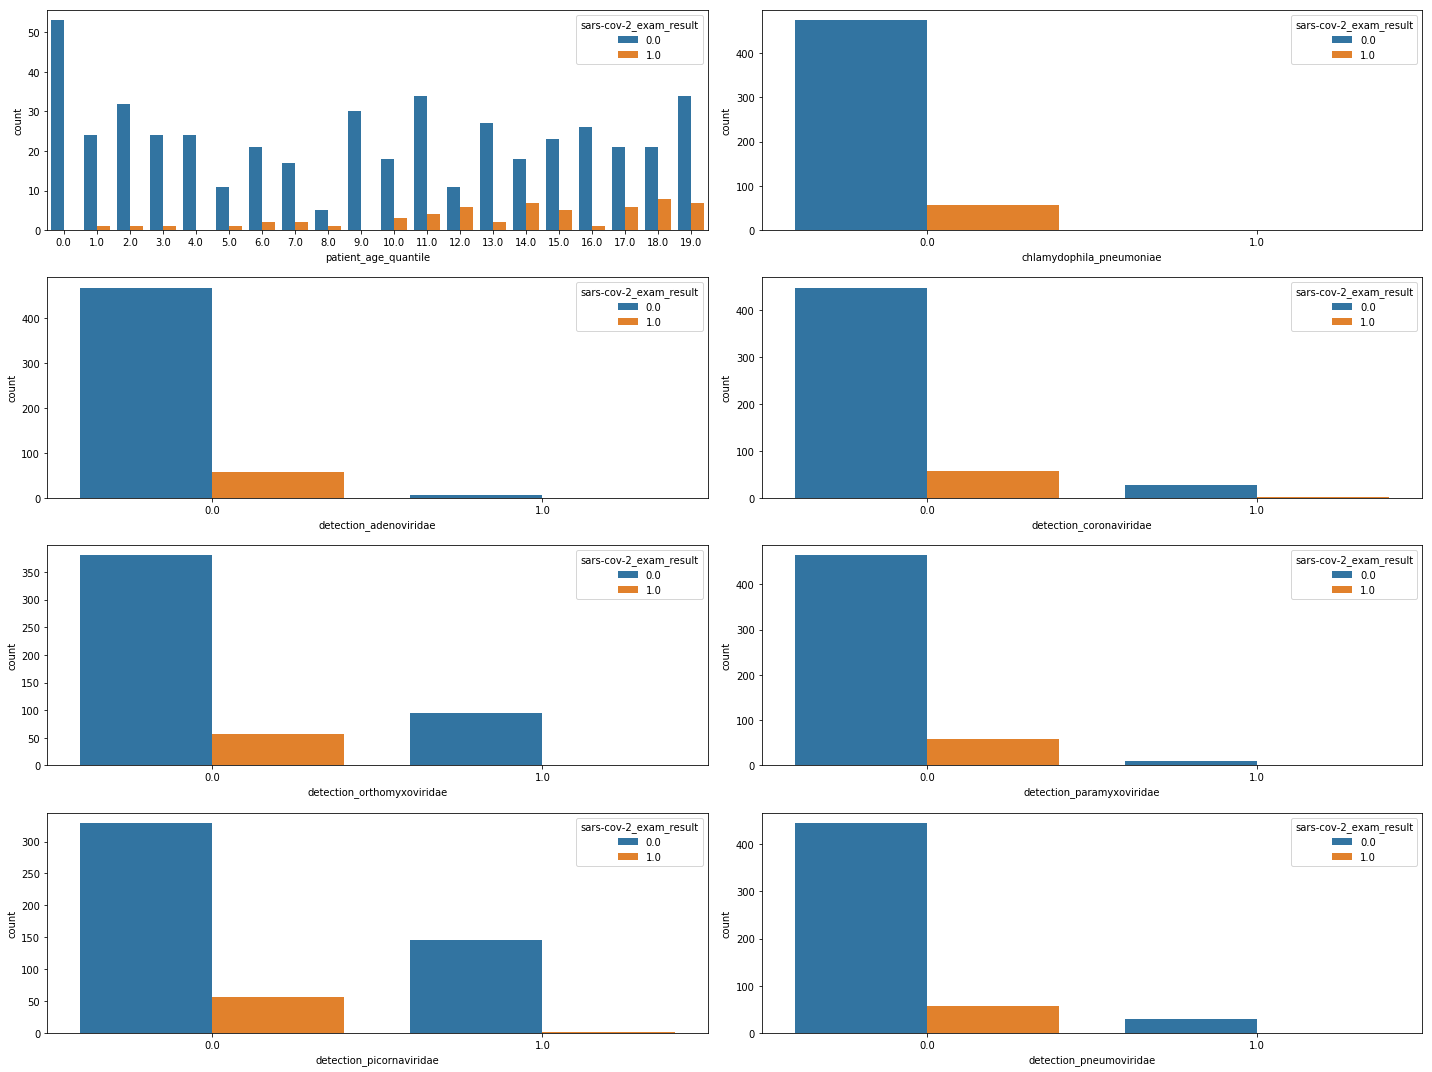

In [63]:
# PLOT - Barplots over our variables
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
r = 0 # Index row
c = 0 # Index col
for f in cat_features:
    # Count Plot
    sns.countplot(x=f, hue='sars-cov-2_exam_result', data=dataset_task1,ax=axes[r][c])
    # Plot configs
    axes[r][c].legend(title='sars-cov-2_exam_result', loc='upper right')
    # Index control
    c += 1
    if c > 1:
        c = 0
        r += 1

plt.tight_layout()

Through those graphs I can see that: 
- ```chlamydophila_pneumoniae``` becames pratically a constant feature with only 1% for positives cases. So it's necessary to remove from both datasets (task 1 and 2) given no variance.
- ```detection_adenoviridae``` (genus from only one virus specie) is almost constant for task 1 target. 

Let's see class distribution for ```detection_adenoviridae``` feature:


In [65]:
dataset_task1['detection_adenoviridae'].value_counts()

0.0    526
1.0      6
Name: detection_adenoviridae, dtype: int64

In [66]:
dataset_task1['chlamydophila_pneumoniae'].value_counts()

0.0    531
1.0      1
Name: chlamydophila_pneumoniae, dtype: int64

Based in those answers, I will remove both categorical features for task 1 dataset.

In [67]:
dataset_task1.drop(['chlamydophila_pneumoniae', 'detection_adenoviridae'], axis=1, inplace=True)

## Count plot for discrete variables - Task 2

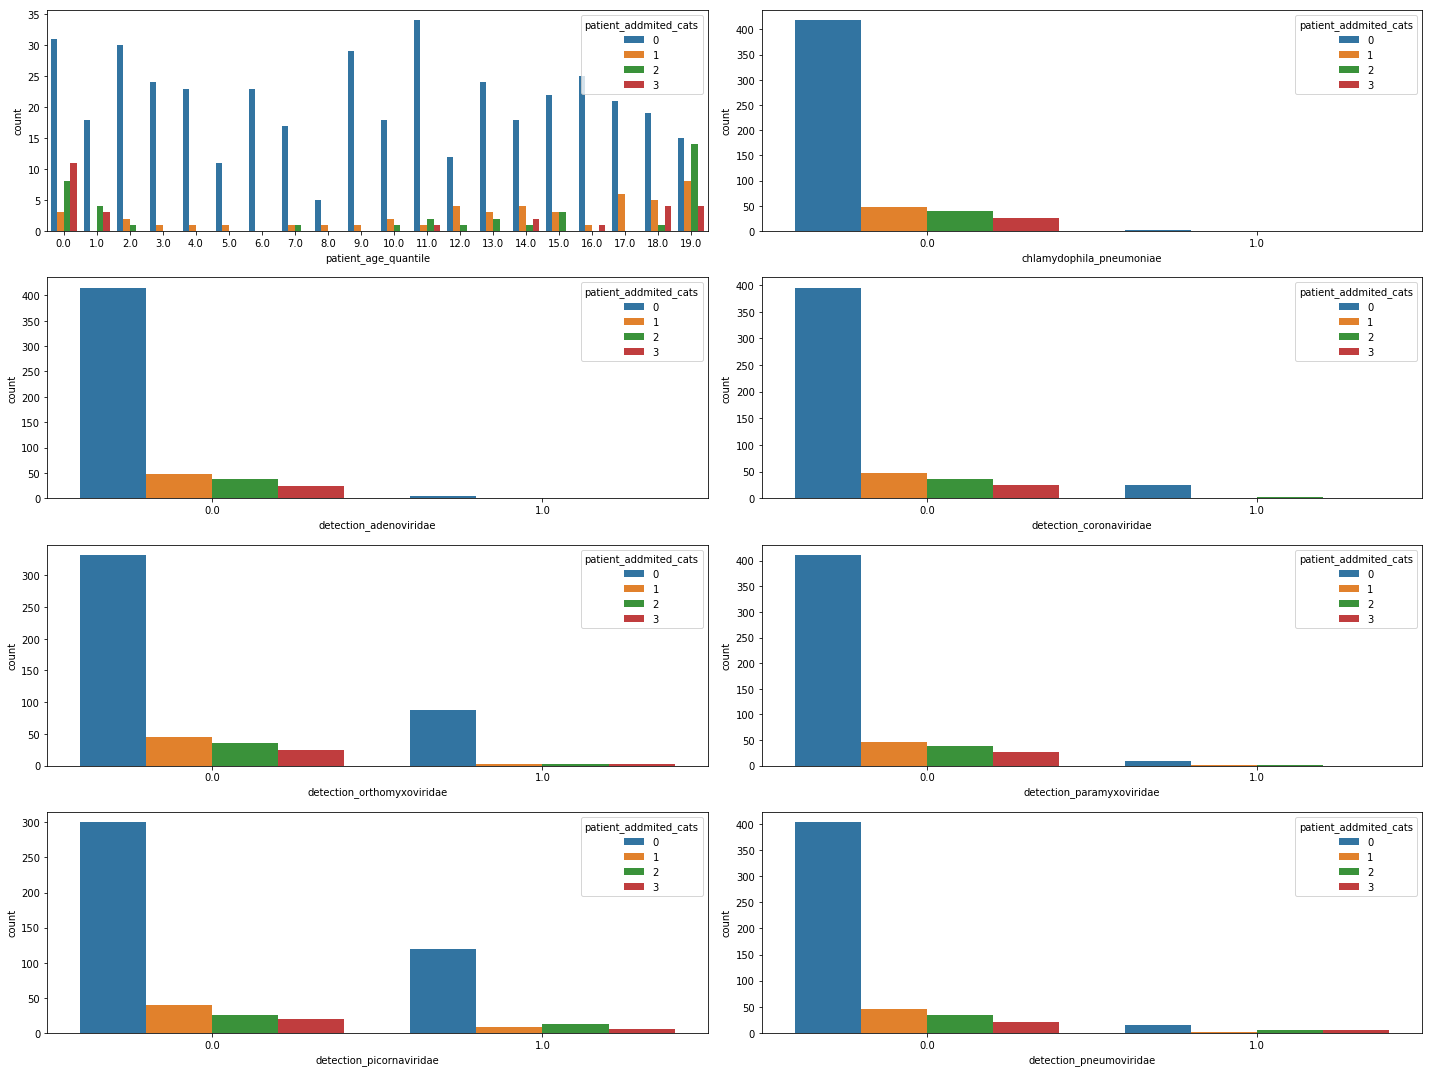

In [68]:
# PLOT - Barplots over our variables
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
r = 0 # Index row
c = 0 # Index col
for f in cat_features:
    # Count Plot
    sns.countplot(x=f, hue='patient_addmited_cats', data=dataset_task2,ax=axes[r][c])
    # Plot configs
    axes[r][c].legend(title='patient_addmited_cats', loc='upper right')
    # Index control
    c += 1
    if c > 1:
        c = 0
        r += 1

plt.tight_layout()

Most of my categorical features presents a similar pattern to ```chlamydophila_pneumoniae``` and ```detection_adenoviridae```. Both will be dropped by the same reasons for task 1 dataset.

In [69]:
dataset_task2.drop(['chlamydophila_pneumoniae', 'detection_adenoviridae'], axis=1, inplace=True)

## Features Overview for model development

In [70]:
# Update cat features
cat_features = list(set(cat_features).difference(set(['chlamydophila_pneumoniae', 'detection_adenoviridae'])))

In [71]:
# update total features
features = num_features + cat_features

In [72]:
# targets
target1 = 'sars-cov-2_exam_result'
target2 = 'patient_addmited_cats'

In [73]:
cat_features

['detection_pneumoviridae',
 'patient_age_quantile',
 'detection_coronaviridae',
 'detection_paramyxoviridae',
 'detection_picornaviridae',
 'detection_orthomyxoviridae']

In [74]:
num_features

['red_blood_cell_distribution_width_(rdw)',
 'mean_corpuscular_volume_(mcv)',
 'lymphocytes',
 'basophils',
 'mean_platelet_volume_',
 'mean_corpuscular_hemoglobin_(mch)',
 'eosinophils',
 'leukocytes',
 'monocytes',
 'hemoglobin',
 'platelets',
 'red_blood_cells',
 'mean_corpuscular_hemoglobin_concentration\xa0(mchc)']

In [75]:
# Print features for models
print('Features Num - ',len(num_features), ' | Features Cat - ', len(cat_features), ' | Total - ', len(cat_features)+len(num_features))

Features Num -  13  | Features Cat -  6  | Total -  19


# Predictive Analysis - General Infos
For both tasks, those infos are necessary to a better comprehension of what I did and why.

## Why Support Vector Machine (SVM)
- It's is a robust model, before deep learning explosion as one of the most used
- Works really well with small datasets. This statement is not applied for Deep Learning models that requires a lot of data to work a correct generalization.
- It's a powerful binary classifier and this problem is a binary classification (TASK 1). Nonetheless, can be applied for multi-class problem (TASK 2)

## Measures againts imbalanced target class
All targets for task 1 and 2 are unbalanced, to avoid this I proposed:
- Train/Test split stratified
- Stratified K-Fold Cross-Validation, keeping the proportion between train/validation split
- Cross Validation Analysis to avoid possible overfit due to small dataset
- Score metrics - balanced accuracy
- Use oversampling technique: SMOTE to increase my samples, turning my dataset more robust and balanced for target classes.
- Evaluate confusion matrix results besides accuracy

**PS**: Stratify keeps the same proportion for target categories in spliting process.

**PS2**: Using SMOTE can be a necessary technique given the fact that I'm working with a small dataset (526 rows) and undersampling techiniques would reduce even more my samples.

## Metrics details
Will be evaluated **balanced accuracy** and a **confusion matrix report**. To understand the last one, let me explaing a binary confusion matrix:

![cm](https://user-images.githubusercontent.com/32513366/77873202-aec63780-721f-11ea-9955-08e3860e2a01.PNG)

Column - Predicted value
Row - Real value

As the target variable is medical in nature, each value in the confusion matrix has a meaning:
- TP (True Positive): If a pacient present COVID-19 and the model predict correct
- TN (True Negative): If a pacient don't present COVID-19 and the model predict correct
- FP (False Positive): If a pacient don't present COVID-19 and the model says that he's infected
- FN (False Negative): If a pacient present COVID-19, but the model says that he's fine

Given the actual world situation, I considered **FN error the worst**: the pacient infected getting out from the hospital could infect others. I will considered **recall** and **accuracy** as the most important measures for this study.

# Task 1
#### Predict confirmed COVID-19 cases among suspected cases. Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?


The discrete count plot presents a weird positive/negative case distribution for the data (few samples are positive). Given this, I will evaluate models using: complete feature space and only numerical features (the same is valid for Task 2).

## Only numerical features

### Split a test set to verify the metrics

In [126]:
# TTSplit
x_train, x_test, y_train, y_test = train_test_split(dataset_task1[num_features], dataset_task1[target1], test_size = 0.20, random_state = 1206, stratify=dataset_task1[target1])

In [127]:
print(len(x_train))

425


### Oversampling technique for trainset: SMOTE

In [128]:
# create smote object
smt = SMOTE(k_neighbors=5, random_state=1206)

# Do the process
x_train, y_train = smt.fit_sample(x_train, y_train)

In [129]:
print(len(x_train))

758


I got more than 300 new samples!

### Grid Search Stratified KFold Cross Validation for SVM Classifier

In [131]:
# Defining parameter range to grid search
param_gridSVM = {'C': [0.1, 1, 10, 100, 1000],
                 'shrinking':[True, False],
                 'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

# Best result found after grid search! This trick is to improve commit speed
param_gridSVM = {'C': [10], 'gamma': [0.1], 'kernel': ['rbf'], 'shrinking': [True]}

# Define grid instance
gridSVM = GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=101), param_grid=param_gridSVM, refit = True, verbose = 1, scoring='balanced_accuracy', n_jobs=3) 

# Initialize grid search, fitting the best model
gridSVM.fit(x_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished


In [132]:
# print best parameter after tuning svm
print(gridSVM.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}


In [133]:
# print how our best model looks after hyper-parameter tuning 
print(gridSVM.best_estimator_) 

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=101, shrinking=True, tol=0.001,
    verbose=False)


### Evaluate Metrics for imputed dataset
Evaluating SVM model performance to answer the first task.

In [134]:
# Make predictions over test set
y_pred_svm = gridSVM.predict(x_test)

In [135]:
# print classification report SVM
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        95
         1.0       0.69      0.75      0.72        12

    accuracy                           0.93       107
   macro avg       0.83      0.85      0.84       107
weighted avg       0.94      0.93      0.94       107



In [136]:
# Confusion Matrix SVM
## original binary labels
labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm, labels=labels), index=labels, columns=labels)
# Visualize labels
cm.index = ['real: 0', 'real: 1']
cm.columns = ['pred: 0', 'pred: 1']

# CM visualization
cm

,pred: 0,pred: 1
real: 0,91,4
real: 1,3,9


## Complete feature space

### Train Test Split, SMOTE and GridSearchCV

In [139]:
# TTSplit
x_train, x_test, y_train, y_test = train_test_split(dataset_task1[features], dataset_task1[target1], test_size = 0.20, random_state = 1206, stratify=dataset_task1[target1])

# Create smote object
smt = SMOTE(k_neighbors=5, random_state=1206)

# Do the process
x_train, y_train = smt.fit_sample(x_train, y_train)

# Defining parameter range to grid search
param_gridSVM = {'C': [0.1, 1, 10, 100, 1000],
                 'shrinking':[True, False],
                 'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

# Best result found after grid search! This trick is to improve commit speed
param_gridSVM = {'C': [10], 'gamma': [0.1], 'kernel': ['rbf'], 'shrinking': [True]}

# Define grid instance
gridSVM = GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=101), param_grid=param_gridSVM, refit = True, verbose = 1, scoring='balanced_accuracy', n_jobs=3) 

# Initialize grid search, fitting the best model
gridSVM.fit(x_train, y_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 650 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 969 tasks      | elapsed: 17.9min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 20.2min finished


In [140]:
# print best parameter after tuning svm
print(gridSVM.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}


### Model prediction and Metrics

In [141]:
# Make predictions over test set
y_pred_svm = gridSVM.predict(x_test)

# print classification report SVM
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        95
         1.0       0.64      0.75      0.69        12

    accuracy                           0.93       107
   macro avg       0.81      0.85      0.82       107
weighted avg       0.93      0.93      0.93       107



### Metrics

In [142]:
# Confusion Matrix SVM
## original binary labels
labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm, labels=labels), index=labels, columns=labels)
# Visualize labels
cm.index = ['real: 0', 'real: 1']
cm.columns = ['pred: 0', 'pred: 1']

# CM visualization
cm

,pred: 0,pred: 1
real: 0,90,5
real: 1,3,9


## Results - Task 1
- The SVM model had a great performance, with a recall (related to **FN error**) of 75% and a  accuracy ~93%. Some test that I didn't present here demonstrate that missing imputation + oversampling SMOTE helped the model improvement (got this idea from [Lucas Moda](https://www.kaggle.com/lukmoda), thanks!)
- The model is robust and could have future implementations given small datasets.
- Even after a hard work to create the family column, my discrete variables didn't present any improvement in the model.

Probably with more complete samples for those continuous features the model can be improved!

# Task 2
**Predict admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases. Based on the results of laboratory tests commonly collected among confirmed COVID-19 cases during a visit to the emergency room, would it be possible to predict which patients will need to be admitted to a general ward, semi-intensive unit or intensive care unit?**

## Only numerical features
### Split a test set to verify the metrics

In [143]:
# ttsplit
x_train, x_test, y_train, y_test = train_test_split(dataset_task2[num_features], dataset_task2[target2], test_size = 0.20, random_state = 1206, stratify=dataset_task2[target2])

### Missing imputation - SMOTE

In [144]:
# create smote object
smt = SMOTE(k_neighbors=5, random_state=1206)

# Do the process
x_train, y_train = smt.fit_sample(x_train, y_train)

### Grid Search Stratified KFold Cross Validation for SVM Classifier

In [145]:
# Defining parameter range to grid search
param_gridSVM = {'C': [0.1, 1, 10, 100, 1000], 
                'shrinking':[True, False],
                 'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

# Best result found after grid search! This trick is to improve commit speed
param_gridSVM = {'C': [100], 'gamma': ['scale'], 'kernel': ['rbf'], 'shrinking': True}

# Define grid instance
gridSVM = GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=101), param_grid=param_gridSVM, refit = True, verbose = 1, scoring='balanced_accuracy', n_jobs=3) 

# Initialize grid search, fitting the best model
gridSVM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=101, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001,
                                   0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [146]:
# print best parameter after tuning 
print(gridSVM.best_params_)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


In [147]:
# print how our best model looks after hyper-parameter tuning 
print(gridSVM.best_estimator_) 

SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=101, shrinking=True, tol=0.001,
    verbose=False)


### Evaluate Metrics

In [148]:
# Make predictions over test set for both models
y_pred_svm = gridSVM.predict(x_test)

In [149]:
# print classification report SVM
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        84
           1       0.50      0.50      0.50        10
           2       0.00      0.00      0.00         8
           3       0.40      0.40      0.40         5

    accuracy                           0.75       107
   macro avg       0.43      0.44      0.44       107
weighted avg       0.72      0.75      0.74       107



In [150]:
# Confusion Matrix SVM
## original binary labels
labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm, labels=labels), index=labels, columns=labels)

# CM visualization
cm

,0,1,2,3
0,73,5,4,2
1,4,5,1,0
2,7,0,0,1
3,3,0,0,2


Reminds that column is predicted and row is actual value.

## Complete feature space

### Train Test Split, SMOTE and GridSearchCV

In [151]:
# TTSplit
x_train, x_test, y_train, y_test = train_test_split(dataset_task2[features], dataset_task2[target2], test_size = 0.20, random_state = 1206, stratify=dataset_task2[target2])

# Create smote object
smt = SMOTE(k_neighbors=5, random_state=1206)

# Do the process
x_train, y_train = smt.fit_sample(x_train, y_train)

# Defining parameter range to grid search
param_gridSVM = {'C': [0.1, 1, 10, 100, 1000],
                 'shrinking':[True, False],
                 'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

# Best result found after grid search! This trick is to improve commit speed
param_gridSVM = {'C': [100], 'gamma': [0.1], 'kernel': ['rbf'], 'shrinking': [True]}

# Define grid instance
gridSVM = GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=101), param_grid=param_gridSVM, refit = True, verbose = 1, scoring='balanced_accuracy', n_jobs=3) 

# Initialize grid search, fitting the best model
gridSVM.fit(x_train, y_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   40.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   57.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.4min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 73.0min finished


In [152]:
# print best parameter after tuning svm
print(gridSVM.best_params_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}


### Model Predictions and Metrics

In [153]:
# Make predictions over test set
y_pred_svm = gridSVM.predict(x_test)

# print classification report SVM
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        84
           1       0.33      0.20      0.25        10
           2       0.40      0.25      0.31         8
           3       0.33      0.20      0.25         5

    accuracy                           0.80       107
   macro avg       0.48      0.40      0.43       107
weighted avg       0.76      0.80      0.78       107



### Metrics

In [155]:
# Confusion Matrix SVM
## original binary labels
labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm, labels=labels), index=labels, columns=labels)

# CM visualization
cm

,0,1,2,3
0,81,3,0,0
1,3,2,3,2
2,5,1,2,0
3,4,0,0,1


Reminds that column is predicted and row is actual value.

## Results - Task 2
- The model provides a good **recall** for '0': 96%, but for classes '1','2' and '3' worst results: 20%, 25% and 20% respectively. The accuracy was 80%, but this value is not reliable given the confusion matrix. Probably, given the small samples quantities for classes '1','2' and '3' SMOTE most generalize points for those categories based in '0'. Further study should be applied to understand better this Task.
- Different from task 1, discrete features improve (a little bit) my model results.

# Conclusions
All pipeline was explained during code development. I learned a lot (as I said before), principally missing data analysis. I can think several possibilities to improve my results:
- Having a bigger dataset
- Try "total attack approach" with all machine learning models through Hunga bunga package, even though SVM is highly recommended for applications with a low sample sizes.

In my Point of View, I had an awesome result in task 1. The task 2 was more complicate given the fact that I needed to predict a categorical feature with 4 classes. Some ways to improve my metrics in this task would be:
- reducing class size (grouping some categories into one)
- trying another ML models
- Understand more the problem related to those target labels.

Look that I'm really confident with my missing analysis, this part was really hard to understand and quite difficult to search.

The family taxonomy columns was a great idea in my opinion, but I think that those columns did not get any impact for task 1 model because:
- Family could be a taxonomy group generic
- The way that I picked my rows (I would make the same choice btw) could be decisive in those results

## Summarizing
**my best model for Task 1 used only numerical features and for Task 2 used discrete + numerical features. SMOTE improved my results for Task 1, but not for Task 2.**

Despite not reaching great metrics, I believe that the architecture presented here demonstrates why I pick each result, graph and decision. Furthermore, I believe that for future databases this same architecture can be applied with a high level of confidence given its mathematical foundation principally missing data analysis, imputation and data exploration.

#### Let's win this fight against Covid-19!